In [2]:
## Import all necessary libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import PIL
import torchvision
import numpy as np
import pandas as pd
import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import seaborn as sns
from matplotlib import RcParams
from torchvision.transforms.transforms import CenterCrop
from sklearn.model_selection import train_test_split
from torchvision.transforms.transforms import CenterCrop
from sklearn.metrics import confusion_matrix

## Set the working directory 
os.chdir('/Users/kajaltiwary/ANLY677_FinalProject/')
path = os.getcwd()

 ## Data Preprocessing

In [3]:
# # Get the subdirectory and file names for each image (FNAME)
# folder_path = (path+'/Images/')
# file_path = [] 
# for root, dirs, files in os.walk(folder_path): 
#     for f in files:
#         file_info = os.path.join(root, f) 
#         file_path.append(file_info)
# lst = [e[47:] for e in file_path]

# ## Get the classes for each image (CLASS)
# classes = [] 
# for i in lst: 
#     split = i.split('/')[0]
#     classes.append(split)
    
# ## Create one dataframe that stores all information 
# df = pd.DataFrame(lst, columns = ['FNAME'])
# df2 = pd.DataFrame(classes, columns = ['CLASS'])
# df.insert(0, 'ID', range(0,  len(df)))
# df2.insert(0, 'ID', range(0,  len(df2)))
# result = pd.merge(df, df2, on="ID")

# ## Map the categorical class values to numeric values 
# conditions = [
#     (result['CLASS'] == 'Ground_Squirrel'),
#     (result['CLASS'] == 'Red_Fox'),
#     (result['CLASS'] == 'Bald_Eagle'),
#     (result['CLASS'] == 'Elk'),
#     (result['CLASS'] == 'Black_Bear'),
#     (result['CLASS'] == 'Beaver'),
#     (result['CLASS'] == 'Wolf'),
#     (result['CLASS'] == 'Gastropods'),
#     (result['CLASS'] == 'River_Otter'),
#     (result['CLASS'] == 'Bighorn_Sheep'),
#     (result['CLASS'] == 'Grizzly_Bear'),
#     (result['CLASS'] == 'Bull_Moose'),
#     (result['CLASS'] == 'Bison'),
#     (result['CLASS'] == 'Deer'),
#     (result['CLASS'] == 'Badger')]
# choices = [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14]
# result['CLASS'] = np.select(conditions, choices)

# ## View the final dataframe 
# result.head()

In [4]:
# ## Create a train test split 
# # train_df, test_df = train_test_split(result, test_size=0.2)
# train_df['SPLIT'] = 1 
# test_df['SPLIT'] = 0

In [5]:
# ## Print the first few rows of the training data frame 
# print(train_df.shape)
# train_df.head(10)

In [6]:
# ## Print the first few rows of the test data frame 
# print(test_df.shape)
# test_df.head(10)

In [7]:
# ## Create train and test folders 
train_path = "/Users/kajaltiwary/ANLY677_FinalProject/train/"
# if not os.path.exists(train_path):
#     os.makedirs(train_path)

test_path = "/Users/kajaltiwary/ANLY677_FinalProject/test/"
# if not os.path.exists(test_path):
#     os.makedirs(test_path)

In [8]:
# ## Move images from the main folder to the training folder 
# for _,row in train_df.iterrows():
#     path = "/Users/kajaltiwary/ANLY677_FinalProject/Images/" + row["FNAME"]
#     label = "/Users/kajaltiwary/ANLY677_FinalProject/train/jpg/" + row["FNAME"].split('.')[1].split('/')[0]
    
#     if not os.path.exists(label):
#         os.makedirs(label)
    
#     target = label + '/'+ row["FNAME"].split('/')[-1]
    
#     shutil.move(path, target)

In [9]:
# ## Move images from main folder to the test folder 
# for _,row in test_df.iterrows():
#     path = "/Users/kajaltiwary/ANLY677_FinalProject/Images/" + row["FNAME"]
#     label = "/Users/kajaltiwary/ANLY677_FinalProject/test/jpg/" + row["FNAME"].split('.')[1].split('/')[0]
    
#     if not os.path.exists(label):
#         os.makedirs(label)
        
#     target = label + '/'+ row["FNAME"].split('/')[-1]
    
#     shutil.move(path, target)

In [10]:
## Define the function to transform images / conduct bootstrapping 
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')

mean = [0.5683, 0.5578, 0.5178]
std = [0.2378, 0.2437, 0.2670]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 32,
    shuffle=True,
    num_workers=0
) 

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 32,
    shuffle=True,
    num_workers=0
)

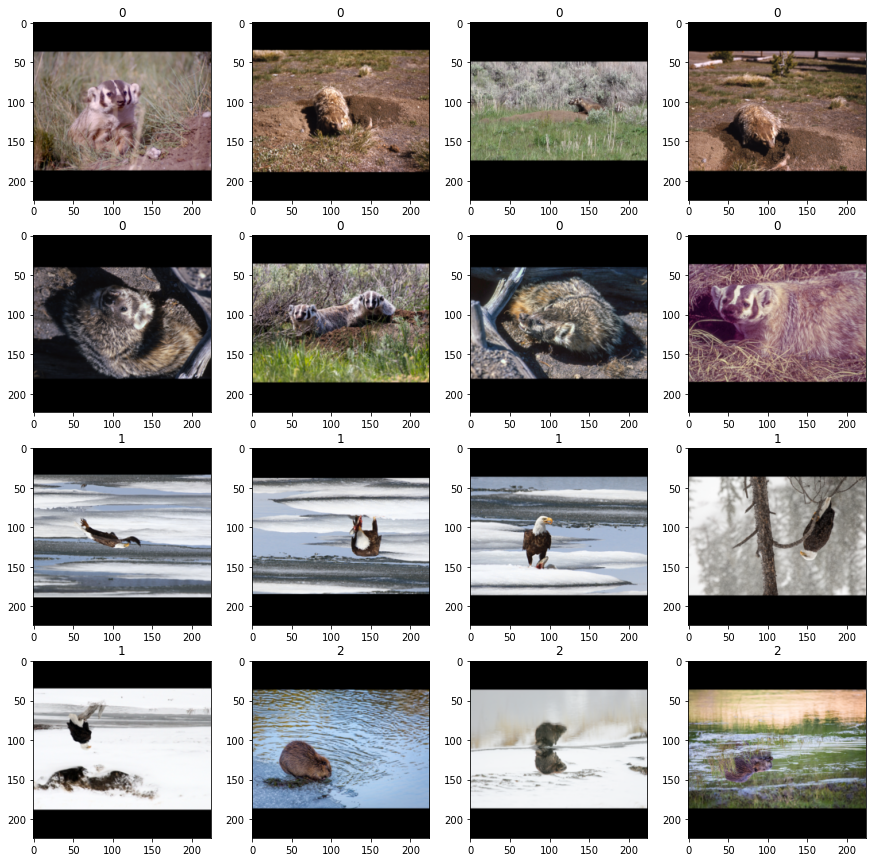

In [11]:
## Plot the images and save in appropriate files 
fig, axes = plt.subplots(4,4,figsize= (15,15))
for i in range(16):
    img = train[i][0].numpy().transpose(1, 2, 0)
    img = np.clip((std * img) + mean, 0, 1)
    axes.flat[i].imshow(img)
    axes.flat[i].set_title(str(train[i][1]))
# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
fig.savefig('/Users/kajaltiwary/ANLY677_FinalProject_1/VGG_Analysis/train_image_transformations.jpg', dpi=300, bbox_inches='tight')  
fig.savefig('/Users/kajaltiwary/ANLY677_FinalProject_1/VGG_Analysis/train_image_transformations.pdf', dpi=300, bbox_inches='tight')  
plt.show()

 ## VGG 16

In [12]:
## Load pre-trained model 
VGGpretrained = torchvision.models.vgg16(pretrained= True)
VGGpretrained.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)
print(VGGpretrained)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
## Define optimizer 
optimizer = optim.SGD(params = VGGpretrained.parameters(), lr= 1e-3, momentum= 0.9 )
criterion = nn.CrossEntropyLoss()

In [14]:
## Get the train and test accuracy / loss 
EPOCHS = 50
train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

VGGpretrained.train()

pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
    total, correct, running_loss = 0, 0, 0
    for batch_idx, (data,target) in enumerate(train_loader):
        VGGpretrained.train()
        optimizer.zero_grad()
        out = VGGpretrained(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        current_loss = loss.cpu().data.item()
        running_loss += current_loss

        _, predicted = out.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().cpu().item()
          
        pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

    test_total, test_correct, test_running_loss = 0, 0, 0
    VGGpretrained.eval()

    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(test_loader):
            out = VGGpretrained(data)
            loss = criterion(out, target)
            test_running_loss += loss.cpu().data.item()
            
            _, predicted = out.max(1)
            test_total += target.size(0)
            test_correct += predicted.eq(target).sum().cpu().item()

        test_accu=100.*test_correct/test_total
        LTest = test_running_loss/len(test_loader)

        if test_accu > best_test_acc:
            best_test_acc = test_accu

            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)
      
            best_snapshot_path = os.path.join(f'VGG_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
            torch.save(VGGpretrained.state_dict(), best_snapshot_path)

    LTrain=running_loss/len(train_loader)
    accu=100.*correct/total
    
    train_accuracy.append(accu)
    test_accuracy.append(test_accu)
    train_loss.append(LTrain)
    test_loss.append(LTest)

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

    pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.001	  Epoch Loss: 0.002	 Train Acc: 100.000%	 Test Loss: 10.818	 Test Acc: 4.545%	: 100%|██████████| 50/50 [1:19:40<00:00, 79.08s/it]

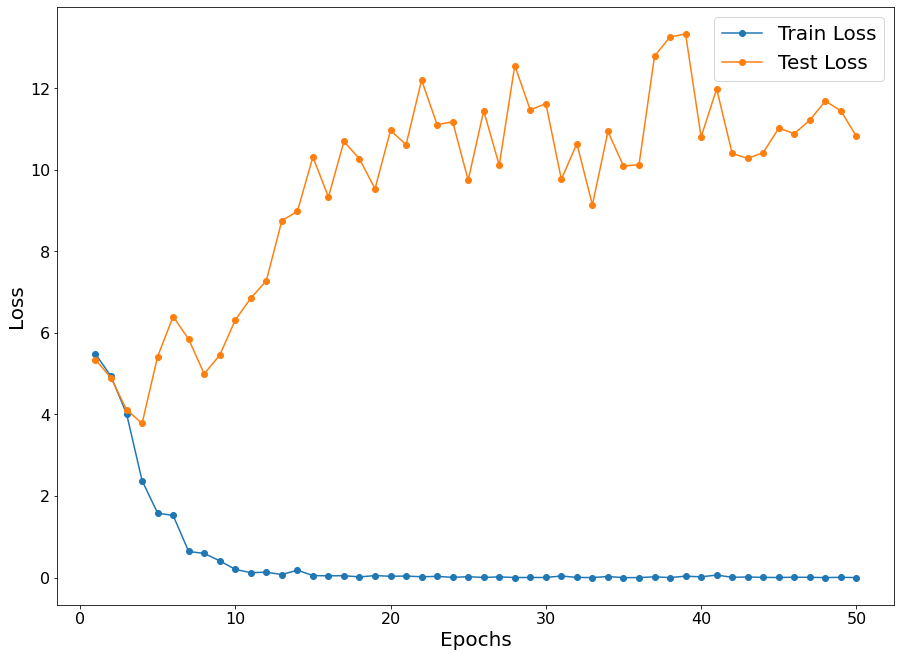

In [15]:
## Plot the loss along with the number of epochs 
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)
ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16)

ax.legend(fontsize = 20)
plt.show()

In [16]:
x_list = x.tolist() 
df = pd.DataFrame(list(zip(x_list, train_loss, test_loss)), columns = ['EPOCH','Train_Loss','Test_Loss'])
df.to_csv('VGG16_Loss_2.csv')

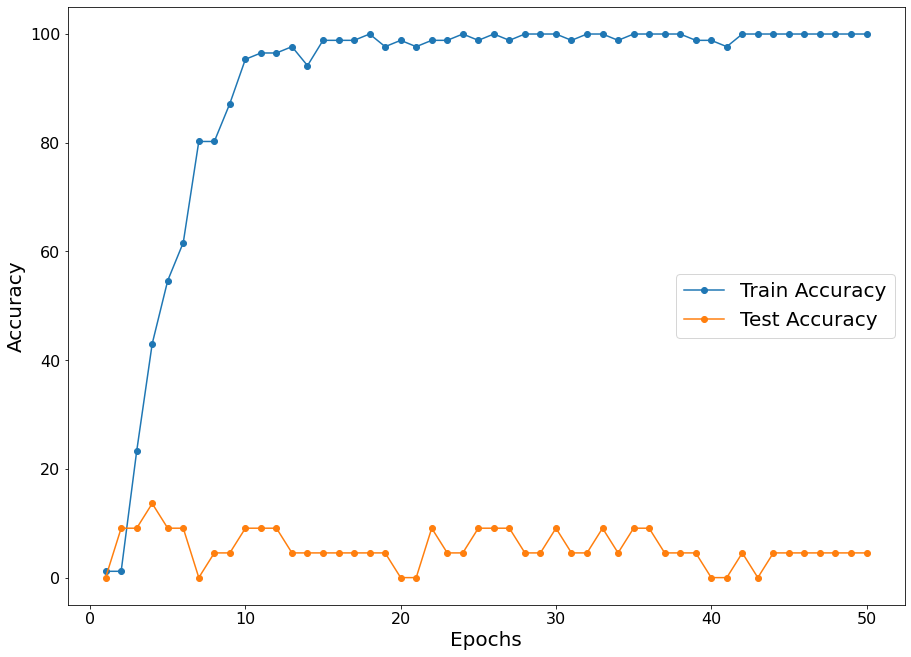

In [17]:
## Plot the accuracy along with the number of epochs 
fig, ax = plt.subplots(figsize =(15,11))
x = np.arange(1,len(train_accuracy)+1)
ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")
ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.tick_params(
    axis = 'both',
    labelsize = 16)
ax.legend(fontsize = 20)
plt.show()

In [18]:
x_list = x.tolist() 
df = pd.DataFrame(list(zip(x_list, train_accuracy, test_accuracy)), columns = ['EPOCH','Train_Accuracy','Test_Accuracy'])
df.to_csv('VGG16_Accuracy_2.csv')

In [19]:
VGGpretrained.load_state_dict(torch.load(best_snapshot_path))

<All keys matched successfully>

In [20]:
## Calculate the percentage of correct classification 
correct = 0
total = 0

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained(data)
        for _,i in enumerate(out):
            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1
correct/total

correct/total

0.13636363636363635

In [21]:
## Calculate the percentage of correct classification 
correct = 0
total = 0

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained(data)
        for _,i in enumerate(out):
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1
correct/total
correct/total

0.2727272727272727

In [22]:
## Calculate the predictions 
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained(data)
        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

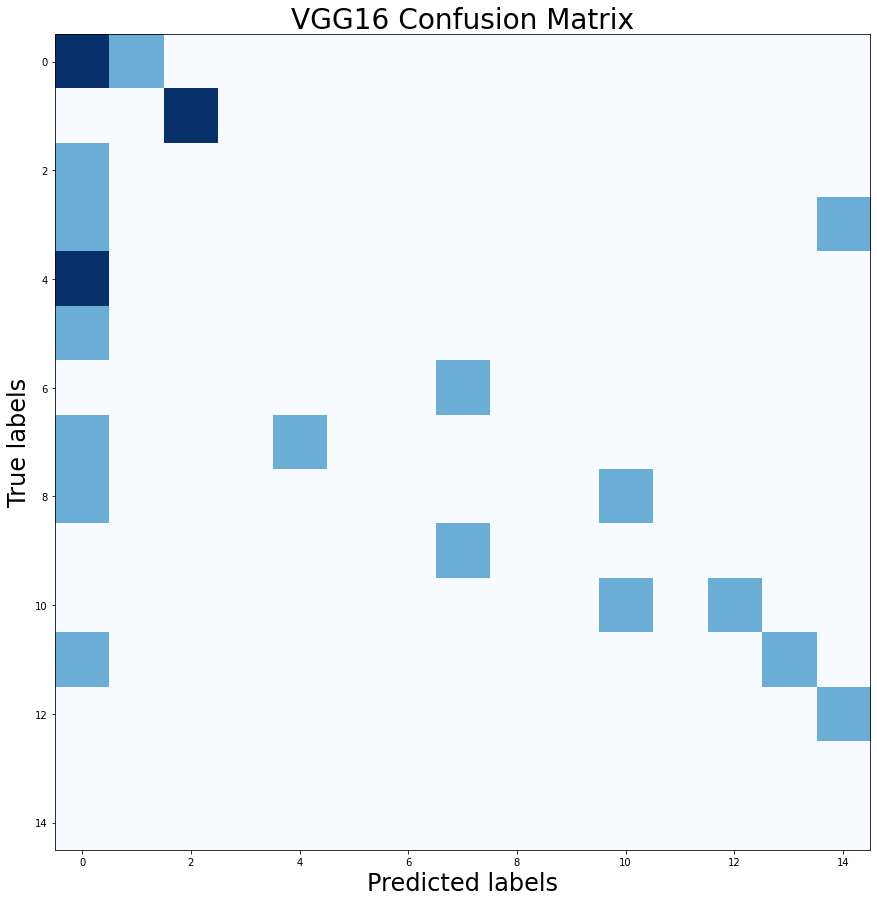

In [23]:
## Plot the confusion matrix to show accuracy classification 
conf = confusion_matrix(y_pred= pred, y_true = correct)
fig,ax = plt.subplots(figsize = (15,15))

label_font = {'size':'24'} 
title_font = {'size':'28'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);
ax.set_title('VGG16 Confusion Matrix', fontdict=title_font);


plt.imshow(conf, interpolation='none', cmap = 'Blues')
plt.savefig('/Users/kajaltiwary/ANLY677_FinalProject/Project3_Final_Graphs/vgg/confusion_matrix_vgg16_2.jpg', dpi=300, bbox_inches='tight') 

In [24]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def calc_accuracy(model, dataloader):
    model.eval()
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.cpu().float(), labels.cpu().long()
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [27]:
top1,top5 = calc_accuracy(VGGpretrained, test_loader)

In [28]:
top1_2 = top1.avg.cpu().detach().numpy()
print(top1_2)

13.636364


In [29]:
top5_2 = top5.avg.cpu().detach().numpy()
print(top5_2)

27.272728


 ## VGG 19

In [30]:
VGGpretrained2 = torchvision.models.vgg19(pretrained= True)
VGGpretrained2.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)
print(VGGpretrained2)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [31]:
## Define optimizer 
optimizer = optim.SGD(params = VGGpretrained2.parameters(), lr= 1e-3, momentum= 0.9 )
criterion = nn.CrossEntropyLoss()

In [32]:
## Get the train and test accuracy / loss 
EPOCHS = 50
train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

VGGpretrained2.train()

pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
    total, correct, running_loss = 0, 0, 0
    for batch_idx, (data,target) in enumerate(train_loader):
        VGGpretrained2.train()
        optimizer.zero_grad()
        out = VGGpretrained2(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        current_loss = loss.cpu().data.item()
        running_loss += current_loss

        _, predicted = out.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().cpu().item()
          
        pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

    test_total, test_correct, test_running_loss = 0, 0, 0
    VGGpretrained2.eval()

    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(test_loader):
            out = VGGpretrained2(data)
            loss = criterion(out, target)
            test_running_loss += loss.cpu().data.item()
            
            _, predicted = out.max(1)
            test_total += target.size(0)
            test_correct += predicted.eq(target).sum().cpu().item()

        test_accu=100.*test_correct/test_total
        LTest = test_running_loss/len(test_loader)

        if test_accu > best_test_acc:
            best_test_acc = test_accu

            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)
      
            best_snapshot_path = os.path.join(f'VGG_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
            torch.save(VGGpretrained2.state_dict(), best_snapshot_path)

    LTrain=running_loss/len(train_loader)
    accu=100.*correct/total
    
    train_accuracy.append(accu)
    test_accuracy.append(test_accu)
    train_loss.append(LTrain)
    test_loss.append(LTest)

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

    pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.001	  Epoch Loss: 0.003	 Train Acc: 100.000%	 Test Loss: 11.089	 Test Acc: 9.091%	: 100%|██████████| 50/50 [1:32:28<00:00, 109.08s/it]

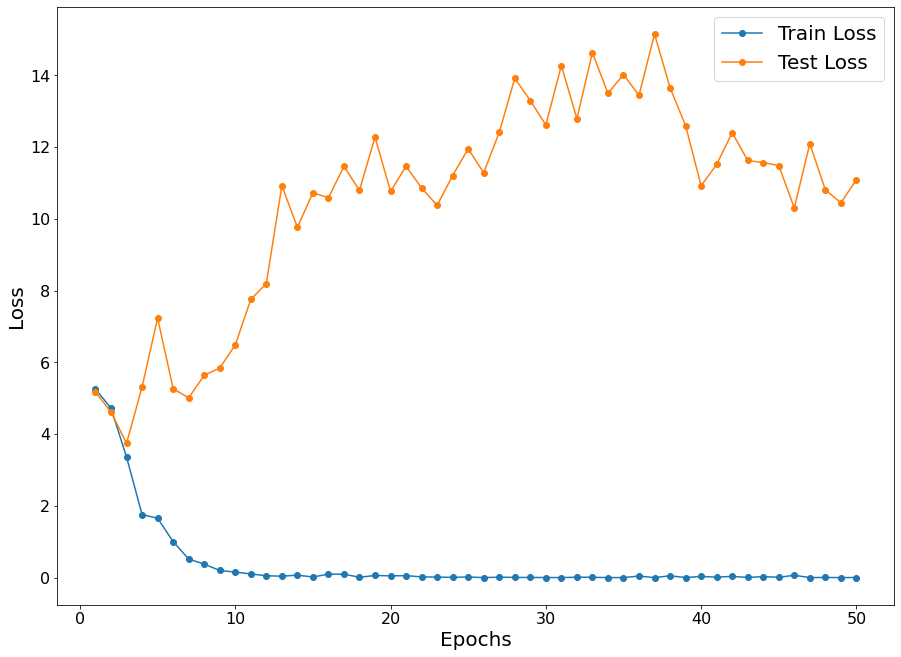

In [33]:
## Plot the loss along with the number of epochs 
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)
ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16)

ax.legend(fontsize = 20)

plt.show()

In [34]:
x_list = x.tolist() 
df = pd.DataFrame(list(zip(x_list, train_loss, test_loss)), columns = ['EPOCH','Train_Loss','Test_Loss'])
df.to_csv('VGG19_Loss_2.csv')

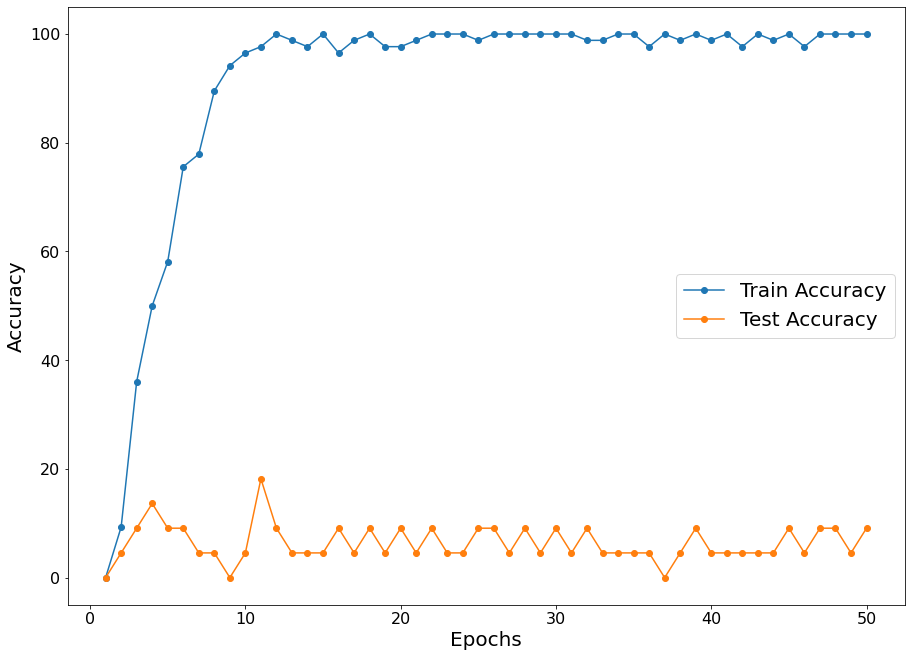

In [35]:
## Plot the accuracy along with the number of epochs 
fig, ax = plt.subplots(figsize =(15,11))
x = np.arange(1,len(train_accuracy)+1)
ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")
ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.tick_params(
    axis = 'both',
    labelsize = 16)
ax.legend(fontsize = 20)
plt.show()

In [36]:
x_list = x.tolist() 
df = pd.DataFrame(list(zip(x_list, train_accuracy, test_accuracy)), columns = ['EPOCH','Train_Accuracy','Test_Accuracy'])
df.to_csv('VGG19_Accuracy_2.csv')

In [37]:
## Load pretrained model with according parameters 
VGGpretrained2.load_state_dict(torch.load(best_snapshot_path))

<All keys matched successfully>

In [38]:
## Calculate the percentage of correct classification 
correct = 0
total = 0

VGGpretrained2.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained2(data)
        for _,i in enumerate(out):
            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1
correct/total

0.09090909090909091

In [39]:
## Calculate the percentage of correct classification 
correct = 0
total = 0

VGGpretrained2.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained2(data)
        for _,i in enumerate(out):
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1
correct/total

0.36363636363636365

In [40]:
## Calculate the predictions 
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

VGGpretrained2.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained2(data)
        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

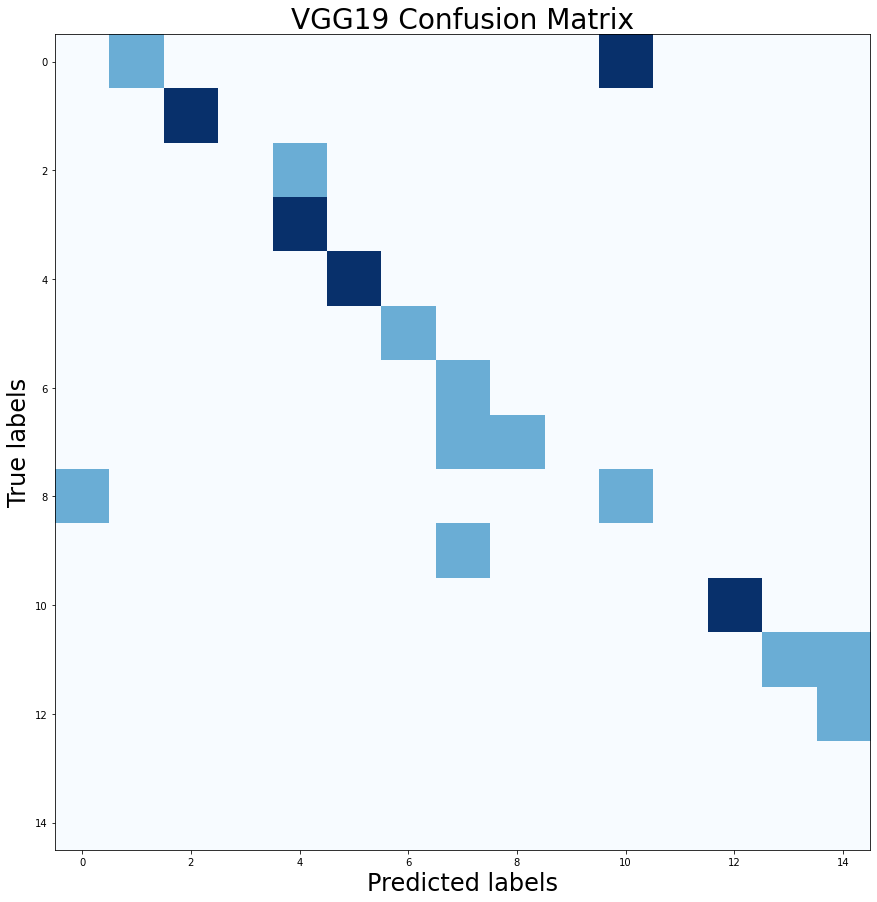

In [41]:
## Plot the confusion matrix to show accuracy classification 
conf = confusion_matrix(y_pred= pred, y_true = correct)
fig,ax = plt.subplots(figsize = (15,15))

label_font = {'size':'24'} 
title_font = {'size':'28'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);
ax.set_title('VGG19 Confusion Matrix', fontdict=title_font);

plt.imshow(conf, interpolation='none', cmap = 'Blues')
plt.savefig('/Users/kajaltiwary/ANLY677_FinalProject/Project3_Final_Graphs/vgg/confusion_matrix_vgg19_2.jpg', dpi=300, bbox_inches='tight') 

In [42]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [43]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [44]:
def calc_accuracy(model, dataloader):
    model.eval()
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.cpu().float(), labels.cpu().long()
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [45]:
top1,top5 = calc_accuracy(VGGpretrained2, test_loader)

In [46]:
top1_2 = top1.avg.cpu().detach().numpy()
print(top1_2)

9.090909


In [47]:
top5_2 = top5.avg.cpu().detach().numpy()
print(top5_2)

36.363636


 ## VGG 13

In [48]:
VGGpretrained3 = torchvision.models.vgg13(pretrained= True)
VGGpretrained3.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)
print(VGGpretrained3)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [49]:
## Define optimizer 
optimizer = optim.SGD(params = VGGpretrained3.parameters(), lr= 1e-3, momentum= 0.9 )
criterion = nn.CrossEntropyLoss()

In [50]:
## Get the train and test accuracy / loss 
EPOCHS = 50
train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

VGGpretrained3.train()

pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
    total, correct, running_loss = 0, 0, 0
    for batch_idx, (data,target) in enumerate(train_loader):
        VGGpretrained3.train()
        optimizer.zero_grad()
        out = VGGpretrained3(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        current_loss = loss.cpu().data.item()
        running_loss += current_loss

        _, predicted = out.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().cpu().item()
          
        pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

    test_total, test_correct, test_running_loss = 0, 0, 0
    VGGpretrained3.eval()

    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(test_loader):
            out = VGGpretrained3(data)
            loss = criterion(out, target)
            test_running_loss += loss.cpu().data.item()
            
            _, predicted = out.max(1)
            test_total += target.size(0)
            test_correct += predicted.eq(target).sum().cpu().item()

        test_accu=100.*test_correct/test_total
        LTest = test_running_loss/len(test_loader)

        if test_accu > best_test_acc:
            best_test_acc = test_accu

            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)
      
            best_snapshot_path = os.path.join(f'VGG_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
            torch.save(VGGpretrained3.state_dict(), best_snapshot_path)

    LTrain=running_loss/len(train_loader)
    accu=100.*correct/total
    
    train_accuracy.append(accu)
    test_accuracy.append(test_accu)
    train_loss.append(LTrain)
    test_loss.append(LTest)

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

    pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.001	  Epoch Loss: 0.006	 Train Acc: 100.000%	 Test Loss: 12.180	 Test Acc: 4.545%	: 100%|██████████| 50/50 [1:07:39<00:00, 81.13s/it]

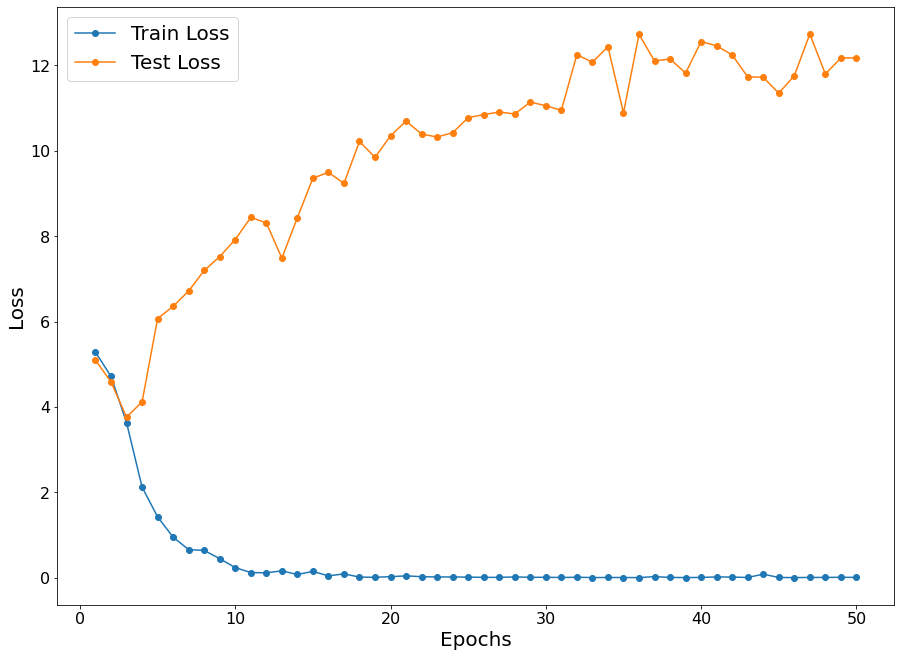

In [51]:
## Plot the loss along with the number of epochs 
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)
ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16)

ax.legend(fontsize = 20)

plt.show()

In [52]:
x_list = x.tolist() 
df = pd.DataFrame(list(zip(x_list, train_loss, test_loss)), columns = ['EPOCH','Train_Loss','Test_Loss'])
df.to_csv('VGG13_Loss_2.csv')

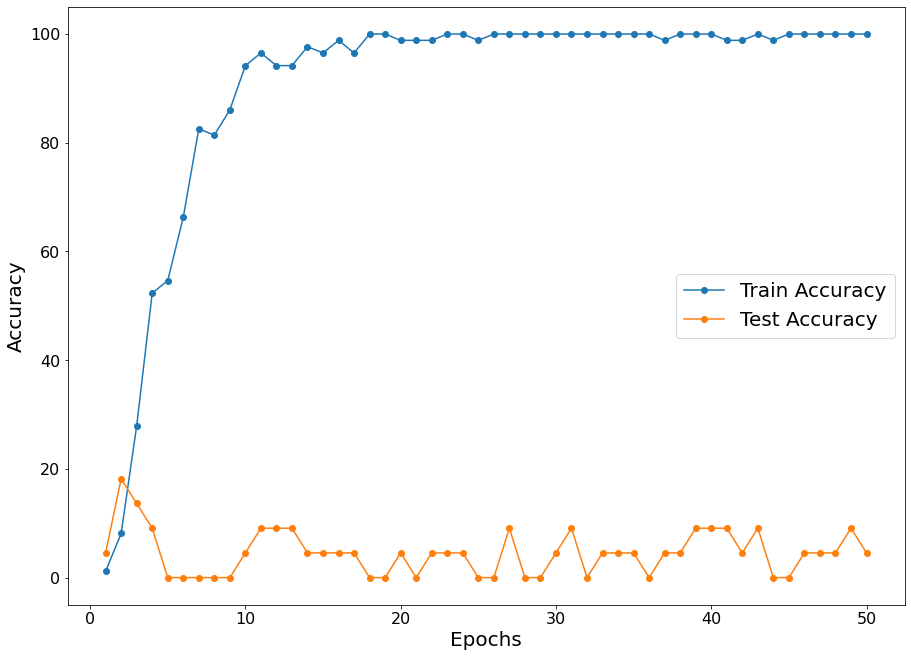

In [53]:
## Plot the accuracy along with the number of epochs 
fig, ax = plt.subplots(figsize =(15,11))
x = np.arange(1,len(train_accuracy)+1)
ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")
ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.tick_params(
    axis = 'both',
    labelsize = 16)
ax.legend(fontsize = 20)
plt.show()

In [54]:
x_list = x.tolist() 
df = pd.DataFrame(list(zip(x_list, train_accuracy, test_accuracy)), columns = ['EPOCH','Train_Accuracy','Test_Accuracy'])
df.to_csv('VGG13_Accuracy_2.csv')

In [55]:
## Load pretrained model with according parameters 
VGGpretrained3.load_state_dict(torch.load(best_snapshot_path))

<All keys matched successfully>

In [56]:
## Calculate the percentage of correct classification 
correct = 0
total = 0

VGGpretrained3.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained3(data)
        for _,i in enumerate(out):
            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1
correct/total

0.13636363636363635

In [57]:
## Calculate the percentage of correct classification 
correct = 0
total = 0

VGGpretrained3.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained3(data)
        for _,i in enumerate(out):
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1
correct/total

0.18181818181818182

In [58]:
## Calculate the predictions 
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

VGGpretrained3.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        out = VGGpretrained3(data)
        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

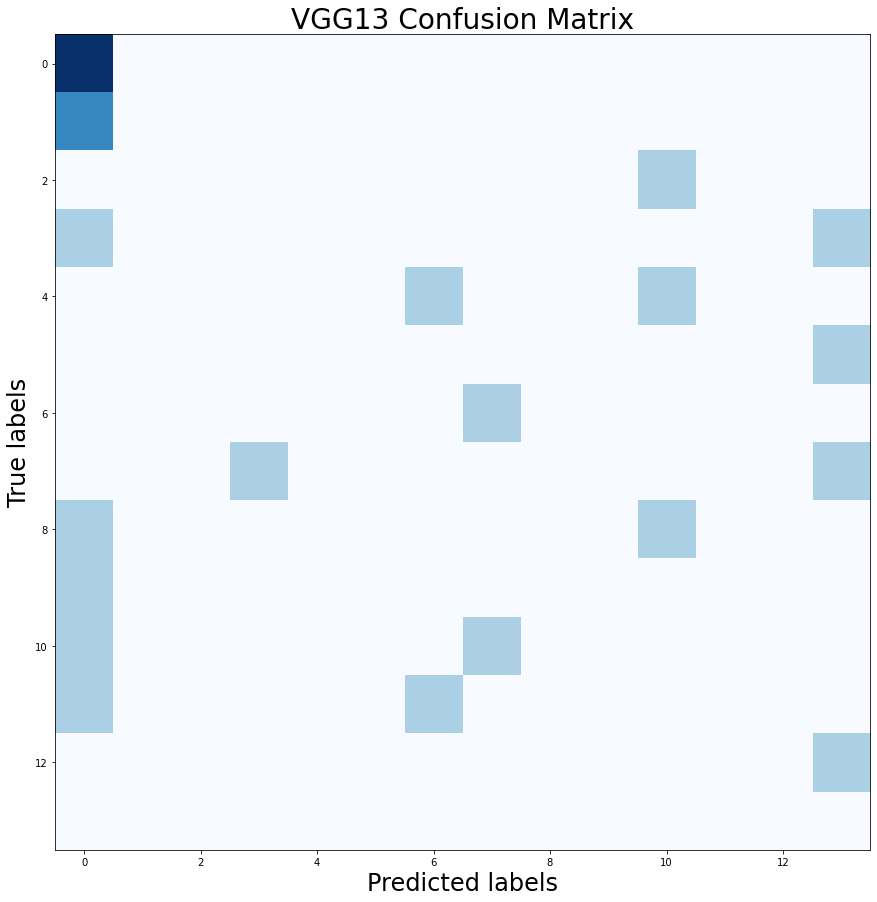

In [59]:
## Plot the confusion matrix to show accuracy classification 
conf = confusion_matrix(y_pred= pred, y_true = correct)
fig,ax = plt.subplots(figsize = (15,15))

label_font = {'size':'24'} 
title_font = {'size':'28'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);
ax.set_title('VGG13 Confusion Matrix', fontdict=title_font);

plt.imshow(conf, interpolation='none', cmap = 'Blues')

plt.savefig('/Users/kajaltiwary/ANLY677_FinalProject/Project3_Final_Graphs/vgg/confusion_matrix_vgg13_2.jpg', dpi=300, bbox_inches='tight') 


In [60]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [61]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [62]:
def calc_accuracy(model, dataloader):
    model.eval()
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.cpu().float(), labels.cpu().long()
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [63]:
top1,top5 = calc_accuracy(VGGpretrained3, test_loader)

In [64]:
top1_2 = top1.avg.cpu().detach().numpy()
print(top1_2)

13.636364


In [65]:
top5_2 = top5.avg.cpu().detach().numpy()
print(top5_2)

22.727272
